In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install FuzzyTM
!{sys.executable} -m pip install pyarrow
!{sys.executable} -m pip install --no-cache-dir --upgrade pandas
!{sys.executable} -m pip install --no-cache-dir --upgrade numpy
!{sys.executable} -m pip install --no-cache-dir --upgrade numexpr
#!{sys.executable} -m pip install PyQt5

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in /home/birgelee/.local/lib/python3.8/site-packages (1.5.3)
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: numpy in /home/birgelee/.local/lib/python3.8/site-packages (1.24.2)
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 381 kB 9.9 MB/s eta 0:00:01


In [1]:
import sys
#import PyQt5
import matplotlib.pyplot as plt
import json
import pyarrow
import pandas
import math
#import pyarrow.feather as feather



In [2]:
colnames=['pid', 'time', 'owd', 'ss', 'bs']

#usecols = ['pid', 'time', 'owd']
#colnames=['pid', 'time', 'owd']


#colnames=['pid', 'time', 'owd', 'ss']

# Should really just save df to feather format in future.

# Since this is a stats file, it needs to be flipped and the NJ states are loaded from the LA file and vice versa.
#owddf = pandas.read_csv("~/stats.example.la.csv", names=colnames, dtype={'time': 'float64', 'owd': 'float64', 'pid': 'int32', 'ss': 'int32'}, header=None, engine="pyarrow")
#owddf = pandas.read_csv("~/stats.example.sp.csv", names=colnames, dtype={'time': 'float64', 'owd': 'float64', 'pid': 'int32', 'ss': 'int32'}, header=None, engine="pyarrow")

# "~/tango-logs/stats.vultrla.full.csv" "stats.vultrstockholm.full.csv"
#owddf = pandas.read_csv("~/tango-logs/stats.vultrla.full.csv", names=colnames, dtype={'time': 'float64', 'owd': 'float64', 'pid': 'int32', 'ss': 'int32', 'bs': 'int32'}, header=None, engine="pyarrow")
owddf2 = pandas.read_csv("~/tango-logs/stats.vultrstockholm.full.csv", names=colnames, dtype={'time': 'float64', 'owd': 'float64', 'pid': 'int32', 'ss': 'int32', 'bs': 'int32'}, header=None, engine="pyarrow")

#owddf = pandas.read_csv("~/stats.head.narrow.la.csv", names=colnames, dtype={'time': 'float64', 'owd': 'float64', 'pid': 'int32'}, header=None, engine="pyarrow")


In [4]:
owddf = owddf2
owddf['owd'] = owddf['owd'].div(10**6) # convert the owd to ms

In [5]:
len(owddf)

2134175444

In [6]:
starttime = owddf['time'].min()

In [7]:
# Remove the time offset and convert to hours
owddf['time'] = owddf['time'].subtract(starttime)
owddf['time'] = owddf['time'].div(60*60)

In [8]:
# Write feather for fast reload.

owddf.to_feather("~/stats.vultrstockholm.full.clean.feather")

In [4]:
# Read feather for fast reload.
#owddf = pandas.read_feather("~/owddf.clean.feather")
#owddf = pandas.read_feather("~/stats.vultrlalarge.200.clean.feather")
#owddf = pandas.read_feather("~/owddfla.head.narrow.clean.feather")

In [9]:
colnames=['pid', 'src', 'dst', 'name'] 

pathidsdf = pandas.read_csv("~/path-ids.csv", names=colnames, dtype={'pid': 'int32', 'src': 'object', 'dst': 'object', 'name': 'object'}, header=None, engine="pyarrow")


In [10]:
nodeIDsToNames = {}
nodeNamesToIDs = {}
for nodeID in range(25):
    prefixID = 0 # Just sample the first prefix to get the node name.
    pid = f"10{nodeID:02d}{prefixID:02d}" # Use type-1 pids
    matchingLine = pathidsdf[pathidsdf['pid'] == int(pid)]['name']
    if len(matchingLine) == 0:
        continue
    nodeNmae = matchingLine.iloc[0].split("_to_")[0]
    nodeIDsToNames[nodeID] = nodeNmae
    nodeNamesToIDs[nodeNmae] = nodeID
    
    

In [11]:
# Separate out data from different source nodes.

owdPerSource = {}
owdPerSourceAllPrefixes = {}
legendMap = {}
legendMapNodePrefix = {}

# Only process type1 (starting with 10) PIDs for node -> BGP prefix destination.
for nodeID in range(25):
    owdPerSource[nodeID] = {}
    legendMapNodePrefix[nodeID] = {}
    allPidsForNode = []
    for prefixID in range(16):
        # Structured based on performance-aware-routing/ebpf/server-module/generate_path_ids_to_print_h.py
        pid = f"10{nodeID:02d}{prefixID:02d}"
        legendMap[pid] = f"{nodeID}_to_8{prefixID:01x}"
        legendMapNodePrefix[nodeID][prefixID] = f"{nodeID}_to_8{prefixID:01x}"
        owdPerSource[nodeID][prefixID] = owddf[owddf['pid'] == int(pid)]
        allPidsForNode.append(int(pid))
        #print(owddf[owddf['pid'] == int(pid)])
    owdPerSourceAllPrefixes[nodeID] = owddf[owddf['pid'].isin(allPidsForNode)]

reverseLegendMap = {v: k for k, v in legendMap.items()}



In [13]:
# Get the series from node 10 to prefix 3
owdPerSource[1][8]

,pid,time,owd,ss,bs
7,100108,401495.153809,50.883963,0,0
189,100108,401495.153812,50.889216,0,0
371,100108,401495.153815,50.882499,0,0
553,100108,401495.153818,50.881090,0,0
735,100108,401495.153821,50.878880,0,0
...,...,...,...,...,...
2134174656,100108,401529.431204,51.982748,0,0
2134174838,100108,401529.431207,51.997690,0,0
2134175020,100108,401529.431210,51.978833,0,0
2134175202,100108,401529.431212,52.008558,0,0


In [14]:
# Get min path latency at node.
#owdPerSourceAllPrefixes[0].head(40)
#owdPerSourceAllPrefixes[0].head(40).rolling(7, step=7).min()
dynamicBestPathOwdPerSource = {}
for node in nodeIDsToNames:
    prefixCountForNode = owdPerSourceAllPrefixes[0].head(20000).groupby('time').count()['pid'].iloc[0]
    dynamicBestPathOwdPerSource[node] = owdPerSourceAllPrefixes[node].rolling(prefixCountForNode, step=prefixCountForNode).min()
    

In [15]:
dynamicBestPathOwdPerSource[22]

,pid,time,owd,ss,bs
154,NaN,NaN,NaN,NaN,NaN
336,102208.0,401495.153809,147.944491,0.0,0.0
518,102208.0,401495.153812,147.959122,0.0,0.0
700,102208.0,401495.153815,147.933286,0.0,0.0
882,102208.0,401495.153818,147.925461,0.0,0.0
...,...,...,...,...,...
2134174623,102208.0,401529.431199,147.575638,0.0,0.0
2134174805,102208.0,401529.431201,147.562506,0.0,0.0
2134174987,102208.0,401529.431204,147.590550,0.0,0.0
2134175169,102208.0,401529.431207,147.576323,0.0,0.0


In [16]:

runningMin = None
runningMax = None
for node in owdPerSource:
    for prefix in owdPerSource[node]:
        if len(owdPerSource[node][prefix]) > 0:
            currentMin = owdPerSource[node][prefix]['time'].min()
            currentMax = owdPerSource[node][prefix]['time'].max()
            if runningMin is None or currentMin < runningMin:
                runningMin = currentMin
            if runningMax is None or currentMax > runningMax:
                runningMax = currentMax
tmin = runningMin
tmax = runningMax

In [17]:
tmax

401529.4312151425

In [15]:
# Once we have the per destination versions, we don't need the originals.
# Saves on RAM
#owddf = None
# Clear up some memory as needed.
#owddf = None
#owddf2 = None

In [29]:
# Old Quantile Code
#for node in owdPerSource:
#    for prefix in owdPerSource[node]:
#        if len(owdPerSource[node][prefix]) > 0:
#            print(f"{node} to {prefix}")
#            print(owdPerSource[node][prefix]['owd'].quantile([.5,.9,.99,.999,.9999,.99999,.999999,.99999999]))

0 to 0
0.500000     66.352342
0.900000     69.588323
0.950000     69.950528
0.990000     71.082163
0.995000     71.359402
0.999000     79.326027
0.999900    121.486858
0.999990    164.140903
0.999999    175.336331
1.000000    177.952823
Name: owd, dtype: float64
0 to 1
0.500000     75.488797
0.900000     78.680584
0.950000     79.066612
0.990000     80.120478
0.995000     80.410442
0.999000     80.641064
0.999900    140.910957
0.999990    145.148071
0.999999    145.961479
1.000000    146.124421
Name: owd, dtype: float64
0 to 2
0.500000    64.992357
0.900000    71.264647
0.950000    71.855628
0.990000    72.588679
0.995000    72.611622
0.999000    72.687182
0.999900    72.714249
0.999990    73.388206
0.999999    75.293511
1.000000    77.125349
Name: owd, dtype: float64
0 to 3
0.500000    69.632851
0.900000    72.814442
0.950000    73.198540
0.990000    74.231730
0.995000    74.523411
0.999000    74.751764
0.999900    74.803231
0.999990    78.757033
0.999999    78.982881
1.000000    81.3

0.500000    15.037084
0.900000    19.032548
0.950000    20.496105
0.990000    22.211323
0.995000    22.347579
0.999000    22.470078
0.999900    22.510445
0.999990    22.560348
0.999999    24.713793
1.000000    27.395637
Name: owd, dtype: float64
5 to 0
0.500000     76.128476
0.900000     80.826647
0.950000     81.395448
0.990000     82.204289
0.995000     82.493911
0.999000     90.037925
0.999900    132.788053
0.999990    140.433703
0.999999    152.146114
1.000000    155.777035
Name: owd, dtype: float64
5 to 1
0.500000     74.660035
0.900000     79.373133
0.950000     79.934219
0.990000     80.810725
0.995000     81.089538
0.999000    105.819825
0.999900    175.185926
0.999990    293.910394
0.999999    357.823415
1.000000    378.261073
Name: owd, dtype: float64
5 to 2
0.500000    68.227892
0.900000    72.841297
0.950000    73.473947
0.990000    74.163070
0.995000    74.472382
0.999000    74.695402
0.999900    74.962135
0.999990    77.439231
0.999999    79.638632
1.000000    87.024389
N

0.500000     72.219001
0.900000     78.451687
0.950000     81.461809
0.990000    157.991413
0.995000    168.897033
0.999000    181.331738
0.999900    206.888364
0.999990    230.660144
0.999999    238.757556
1.000000    240.800729
Name: owd, dtype: float64
9 to 5
0.500000    76.937028
0.900000    82.278401
0.950000    83.600732
0.990000    85.674795
0.995000    86.202884
0.999000    86.605885
0.999900    86.698529
0.999990    88.909469
0.999999    89.047760
1.000000    91.404248
Name: owd, dtype: float64
9 to 6
0.500000     82.001950
0.900000     87.322445
0.950000     88.600736
0.990000     90.772606
0.995000     91.295735
0.999000     91.694580
0.999900    109.213429
0.999990    209.449798
0.999999    264.473318
1.000000    280.590816
Name: owd, dtype: float64
10 to 0
0.500000    100.164638
0.900000    106.318334
0.950000    108.432353
0.990000    112.069091
0.995000    112.620511
0.999000    113.039961
0.999900    113.129529
0.999990    113.158234
0.999999    114.560159
1.000000    1

0.500000    32.340779
0.900000    36.673820
0.950000    37.914192
0.990000    39.570651
0.995000    39.746238
0.999000    39.906052
0.999900    41.578472
0.999990    44.550405
0.999999    51.037071
1.000000    54.102501
Name: owd, dtype: float64
14 to 4
0.500000    29.471440
0.900000    33.802404
0.950000    34.998461
0.990000    36.730651
0.995000    36.906388
0.999000    37.593151
0.999900    87.329204
0.999990    87.867111
0.999999    89.924135
1.000000    92.108144
Name: owd, dtype: float64
14 to 5
0.500000    29.429048
0.900000    33.771035
0.950000    34.953497
0.990000    36.686818
0.995000    36.864659
0.999000    37.550341
0.999900    87.286701
0.999990    87.773800
0.999999    88.302901
1.000000    89.753251
Name: owd, dtype: float64
14 to 6
0.500000    35.833483
0.900000    40.145547
0.950000    41.335927
0.990000    43.061441
0.995000    43.233903
0.999000    43.393371
0.999900    44.862674
0.999990    47.137304
0.999999    49.300253
1.000000    50.347320
Name: owd, dtype: 

0.500000    4.450088e+00
0.900000    9.223372e+12
0.950000    1.844674e+13
0.990000    1.844674e+13
0.995000    1.844674e+13
0.999000    1.844674e+13
0.999900    1.844674e+13
0.999990    1.844674e+13
0.999999    1.844674e+13
1.000000    1.844674e+13
Name: owd, dtype: float64
19 to 1
0.500000    4.271319e+00
0.900000    1.128388e+01
0.950000    1.844674e+13
0.990000    1.844674e+13
0.995000    1.844674e+13
0.999000    1.844674e+13
0.999900    1.844674e+13
0.999990    1.844674e+13
0.999999    1.844674e+13
1.000000    1.844674e+13
Name: owd, dtype: float64
19 to 2
0.500000    4.270194e+00
0.900000    1.135139e+01
0.950000    1.844674e+13
0.990000    1.844674e+13
0.995000    1.844674e+13
0.999000    1.844674e+13
0.999900    1.844674e+13
0.999990    1.844674e+13
0.999999    1.844674e+13
1.000000    1.844674e+13
Name: owd, dtype: float64
19 to 3
0.500000    5.066854e+00
0.900000    1.003654e+01
0.950000    1.163465e+01
0.990000    9.223372e+12
0.995000    1.844674e+13
0.999000    1.844674e+1

0.500000    62.306010
0.900000    65.682463
0.950000    66.202606
0.990000    67.627776
0.995000    68.109820
0.999000    68.817286
0.999900    68.893193
0.999990    69.230284
0.999999    71.783874
1.000000    74.880288
Name: owd, dtype: float64
23 to 4
0.500000     53.557180
0.900000     56.942160
0.950000     57.454952
0.990000     58.825807
0.995000     59.261886
0.999000     59.749308
0.999900    108.111447
0.999990    153.365438
0.999999    154.623902
1.000000    154.778709
Name: owd, dtype: float64
23 to 5
0.500000     49.083464
0.900000     52.469076
0.950000     52.983662
0.990000     54.353069
0.995000     54.795774
0.999000     55.277510
0.999900    103.627843
0.999990    149.024753
0.999999    150.030362
1.000000    150.349159
Name: owd, dtype: float64
23 to 6
0.500000    56.990776
0.900000    60.371780
0.950000    60.881180
0.990000    62.220075
0.995000    62.627666
0.999000    63.111221
0.999900    63.218133
0.999990    63.950858
0.999999    78.499327
1.000000    87.37330

In [18]:
def sumParallelArrays(aSeries, b):
    c = [0] * len(aSeries)
    for i in range(len(aSeries)):
        c[i] = aSeries.iloc[i] + b[i]
    return c

def divArray(a, n):
    return list(map(lambda x: x / n, a))
    

In [19]:
quantilesToCompute = [.5,.9,.99,.999,.9999,.99999,.999999,.9999999,.99999999]
nodesWhereBGPBestpathWasMedianBest = 0
nodesWhereBGPBestpathWasTop99Best = 0
nodeCount = 0

averageBGPBestQuantileArray = [0] * len(quantilesToCompute)
averageMedianBestQuantileArray = [0] * len(quantilesToCompute)
averageTop99BestQuantileArray = [0] * len(quantilesToCompute)

averageDynamicBestQuantileArray = [0] * len(quantilesToCompute)

for node in nodeIDsToNames:
    if nodeIDsToNames[node] in ["vultrsiliconvalley", "vultrla", "vultrstockholm", "vultrfrankfurt"]: # Exclude nodes with OWD glitches.
        continue
    nodeCount += 1
    
    computedQuantilesDynamicBest = dynamicBestPathOwdPerSource[node]['owd'].quantile(quantilesToCompute)
    
    
    medianMinQuantileArray = None
    runningMedianMin = None
    prefixWithMedianMin = None
    
    top99MinQuantileArray = None
    runningtop99Min = None
    prefixWithtop99Min = None
    
    quantilesOfBGPBestpath = None
    prefixCount = 0
    for prefix in owdPerSource[node]:
        if len(owdPerSource[node][prefix]) > 0:
            computedQuantiles = owdPerSource[node][prefix]['owd'].quantile(quantilesToCompute)
            prefixCount += 1
            
            if runningMedianMin == None or computedQuantiles[.5] < runningMedianMin:
                runningMedianMin = computedQuantiles[.5]
                prefixWithMedianMin = prefix
                medianMinQuantileArray = computedQuantiles
                
            if runningtop99Min == None or computedQuantiles[.9999] < runningtop99Min:
                runningtop99Min = computedQuantiles[.9999]
                prefixWithtop99Min = prefix
                top99MinQuantileArray = computedQuantiles
                
            if prefix == 0 or prefix == 8:
                quantilesOfBGPBestpath = computedQuantiles
    optimalMedianMinQuantilesOnBGPBestpath = prefixWithMedianMin in [0,8]
    optimalTop99MinQuantilesOnBGPBestpath = prefixWithtop99Min in [0,8]
    if optimalMedianMinQuantilesOnBGPBestpath:
        nodesWhereBGPBestpathWasMedianBest += 1
    if optimalTop99MinQuantilesOnBGPBestpath:
        nodesWhereBGPBestpathWasTop99Best += 1
    
    averageDynamicBestQuantileArray = sumParallelArrays(computedQuantilesDynamicBest, averageDynamicBestQuantileArray)
    averageBGPBestQuantileArray = sumParallelArrays(quantilesOfBGPBestpath, averageBGPBestQuantileArray)
    averageMedianBestQuantileArray = sumParallelArrays(medianMinQuantileArray, averageMedianBestQuantileArray)
    averageTop99BestQuantileArray = sumParallelArrays(top99MinQuantileArray, averageTop99BestQuantileArray)
                                   
    #print(f"===================\nNode: {nodeIDsToNames[node]},\nBGP Best Quantiles:\n{quantilesOfBGPBestpath}\nOptimal Median Path Quantiles (was BGP best: {optimalMedianMinQuantilesOnBGPBestpath}):\n{medianMinQuantileArray}\nOptimal top .9999 Path Quantiles (was BGP best: {optimalTop99MinQuantilesOnBGPBestpath}):\n{top99MinQuantileArray}")

averageDynamicBestQuantileArray = divArray(averageDynamicBestQuantileArray, nodeCount)  
averageBGPBestQuantileArray = divArray(averageBGPBestQuantileArray, nodeCount)
averageMedianBestQuantileArray = divArray(averageMedianBestQuantileArray, nodeCount)
averageTop99BestQuantileArray = divArray(averageTop99BestQuantileArray, nodeCount)


print(f"Fraction of nodes where BGP Bestpath was median best: {float(nodesWhereBGPBestpathWasMedianBest) / float(nodeCount)}")
print(f"Fraction of nodes where BGP Bestpath was top 9999 best: {float(nodesWhereBGPBestpathWasTop99Best) / float(nodeCount)}")

print(f"Quantiles computed: {quantilesToCompute}")
print(f"Average BGP best quantiles: {averageBGPBestQuantileArray}")
print(f"Average Median best quantiles: {averageMedianBestQuantileArray}")
print(f"Average top 9999 best quantiles: {averageTop99BestQuantileArray}")
print(f"Average dynamic best quantiles: {averageDynamicBestQuantileArray}")



Fraction of nodes where BGP Bestpath was median best: 0.14285714285714285
Fraction of nodes where BGP Bestpath was top 9999 best: 0.19047619047619047
Quantiles computed: [0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 0.9999999, 0.99999999]
Average BGP best quantiles: [75.43412005952379, 85.72876907380952, 90.88265826999998, 106.78057186307164, 133.5023645744307, 161.68883143864574, 182.67248394716893, 201.2985831695648, 206.59000545191205]
Average Median best quantiles: [71.67430057142856, 81.74290780952381, 86.82690339238096, 89.35270590547627, 112.99967081825504, 138.26541404169322, 156.06380580455473, 172.76847173388776, 178.66863213991738]
Average top 9999 best quantiles: [73.29758211904762, 80.35837315238095, 85.33013281309525, 87.02688068654764, 107.93417197403667, 134.20141788003298, 154.49840230142786, 173.2934495662534, 179.12693975654713]
Average dynamic best quantiles: [71.42387165476191, 78.77142276190476, 83.84387630071427, 86.01560326952384, 86.48142285691186, 110.039

In [20]:
quantilesXPos = list(map(lambda q: -math.log10(1 - q),quantilesToCompute))


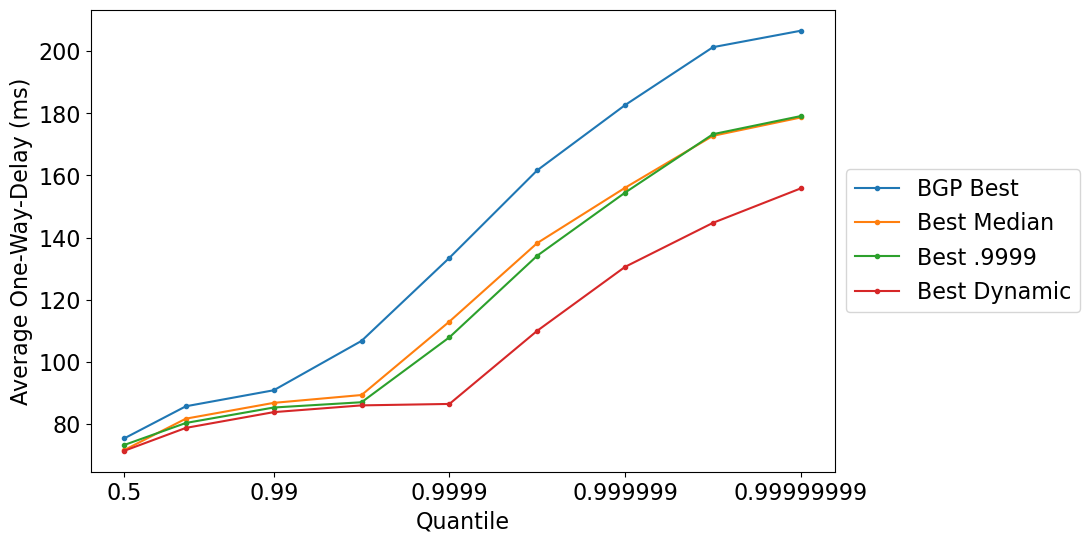

In [21]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12, 6))

graphMinX = 0
graphMaxX = 7
#tstartGraph = 1 #10
#tendGraph = 1.0002 #11
#tstartGraph = 49
#tendGraph = 51



ax.plot(quantilesXPos, averageBGPBestQuantileArray, ".-", label="BGP Best") # consider ".-" marker for dots on line
ax.plot(quantilesXPos, averageMedianBestQuantileArray, ".-", label="Best Median") # consider ".-" marker for dots on line
ax.plot(quantilesXPos, averageTop99BestQuantileArray, ".-", label="Best .9999") # consider ".-" marker for dots on line
ax.plot(quantilesXPos, averageDynamicBestQuantileArray, ".-", label="Best Dynamic") # consider ".-" marker for dots on line

#for dst in owpdatalabm:
#    if not legendMapBM[dst] in ["GTT", "Telia"]:
#        continue
#    ax.plot(owpdatalabm[dst][0], owpdatalabm[dst][1], label=f"{legendMapBM[dst]} Bare Metal")
ax.set_xticks(quantilesXPos[::2])
ax.set_xticklabels(list(map(str, quantilesToCompute[::2])))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


#plt.xlim([tstartGraph, tendGraph])
#plt.xlim([tmin, tmax])

#plt.ylim([0, 300])


ax.set_ylabel('Average One-Way-Delay (ms)')
ax.set_xlabel('Quantile')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.title("Latency of different transit providers vultr LA to NJ across time")
plt.show()

In [105]:
#performanceDegregationThreshold = 1.3
#
#for node in nodeIDsToNames:
#    if nodeIDsToNames[node] in ["vultrsiliconvalley", "vultrla"]: # Exclude nodes with OWD glitches.
#        continue
#    nodeCount += 1
#    for prefix in owdPerSource[node]:
#        if len(owdPerSource[node][prefix]) > 0:
#            if prefix == 0 or prefix == 8:
#                # BGP Bestpath case
#                median = owdPerSource[node][prefix]['owd'].quantile(.5)
#                thresholdVal = performanceDegregationThreshold * median
#                
#    

In [106]:
#lastTime = -500
#eventCount = 0
#eventDurationSum = 0
#currentEventStartTime = None
#for time, owd in gttIncreasedLatency.values:
#    if time - lastTime > 30:
#        eventCount += 1

Node: vultramsterdam (0) OWD


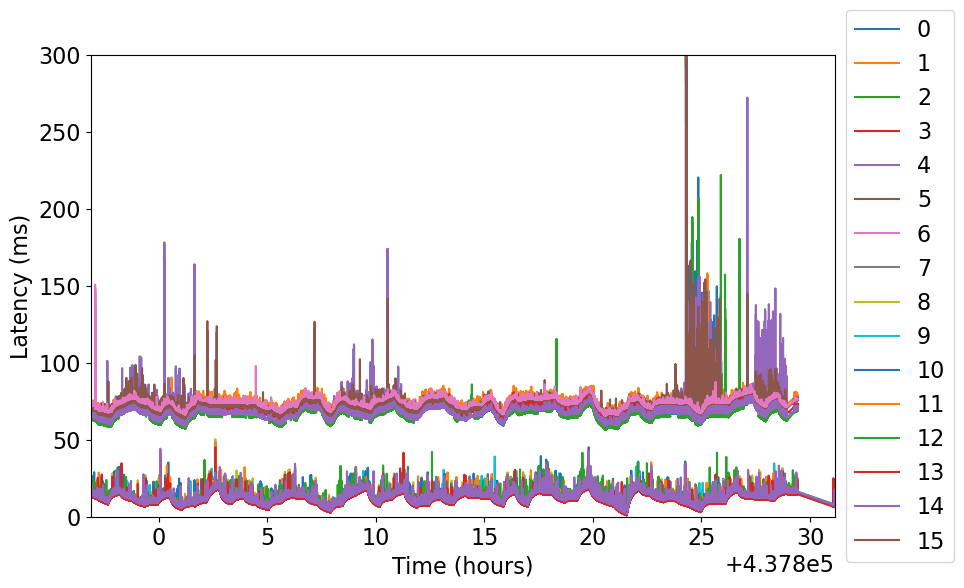

Node: vultratlanta (1) OWD


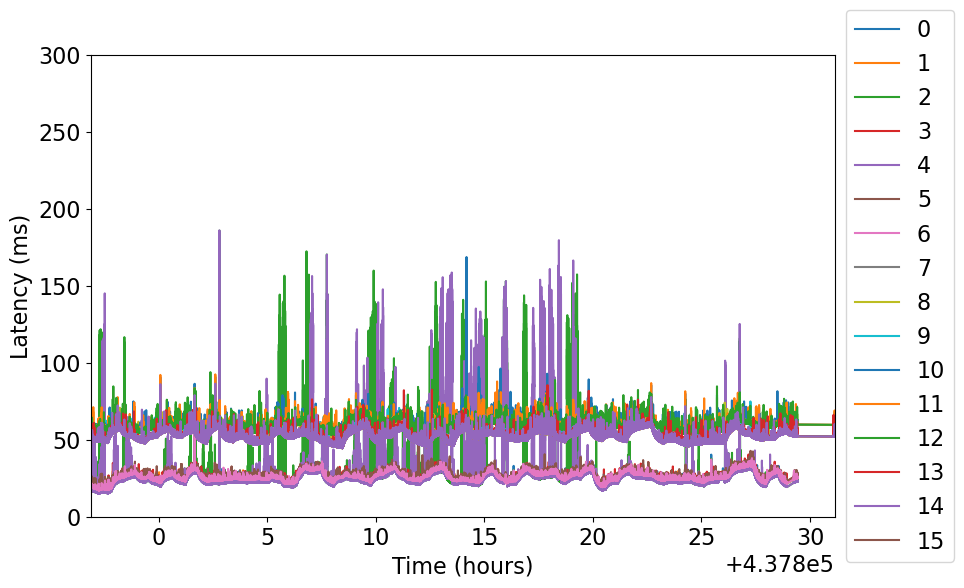

Node: vultrbangalore (2) OWD


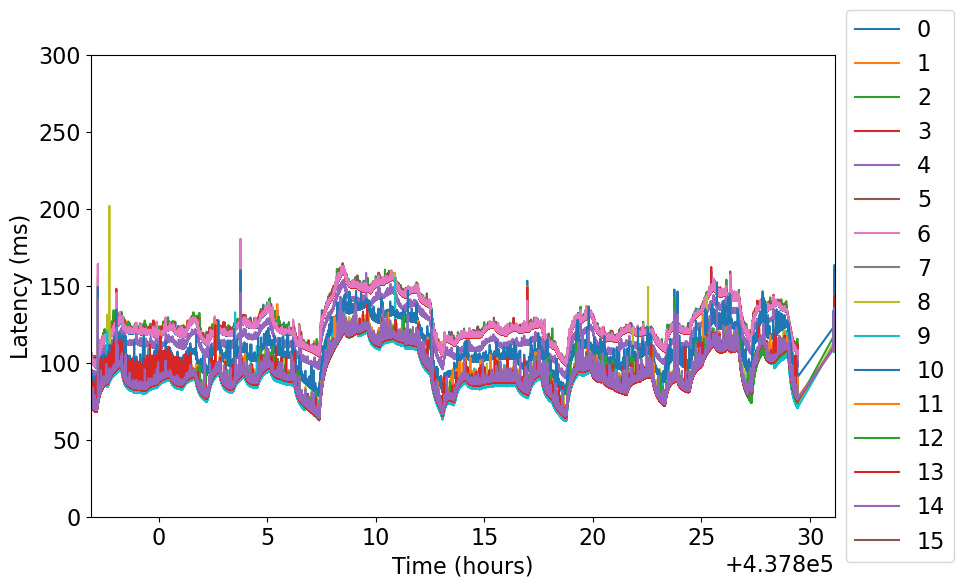

Node: vultrchicago (3) OWD


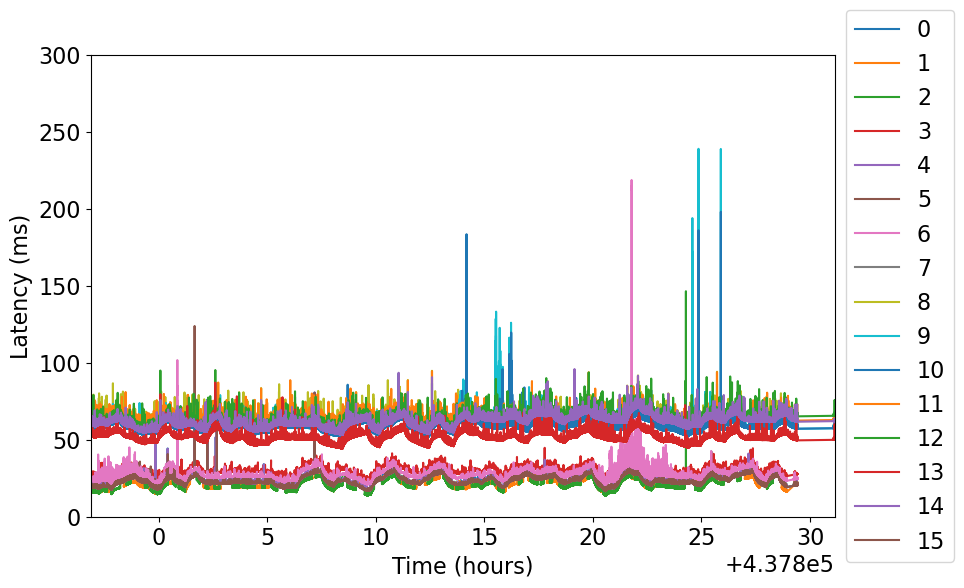

Node: vultrdallas (4) OWD


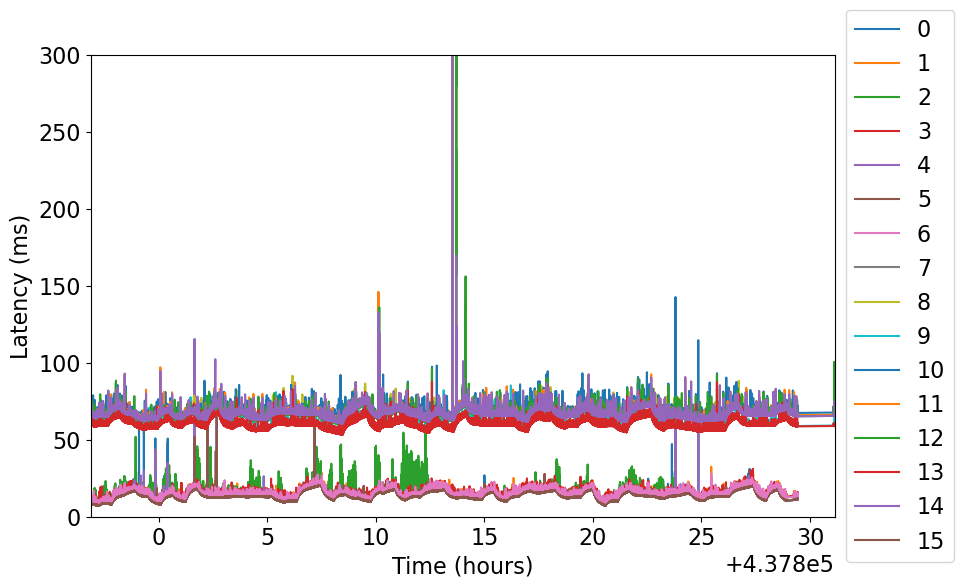

Node: vultrfrankfurt (5) OWD


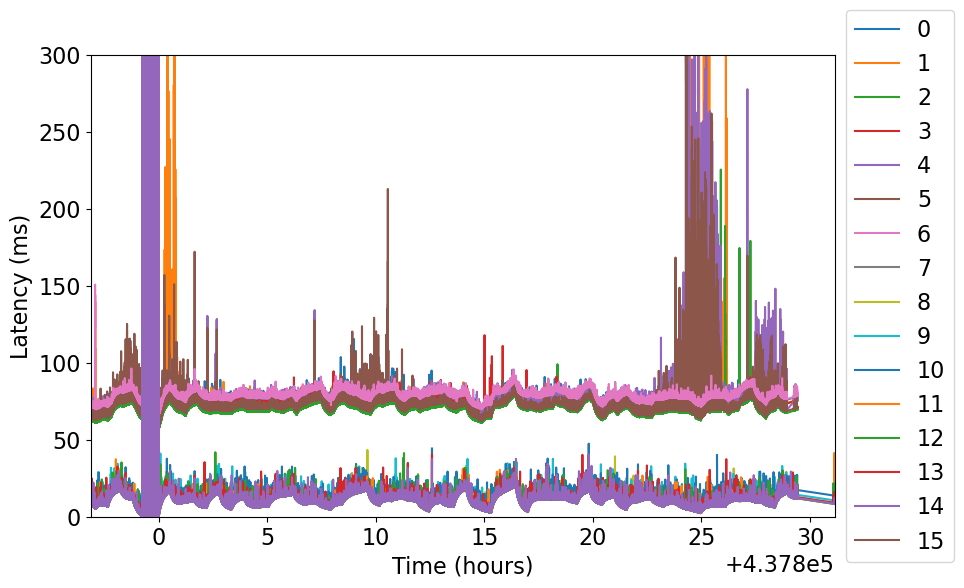

Node: vultrjohannesburg (6) OWD


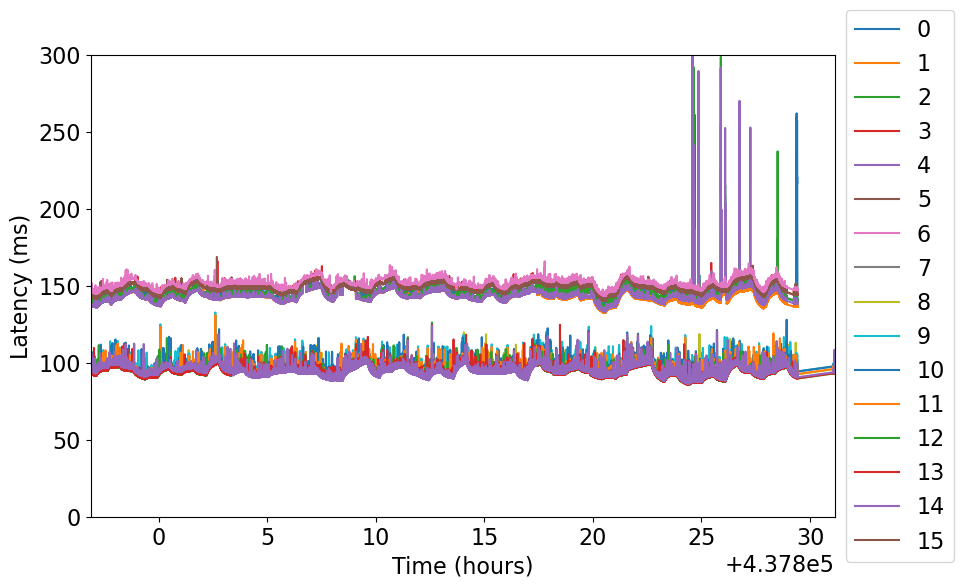

Node: vultrla (7) OWD


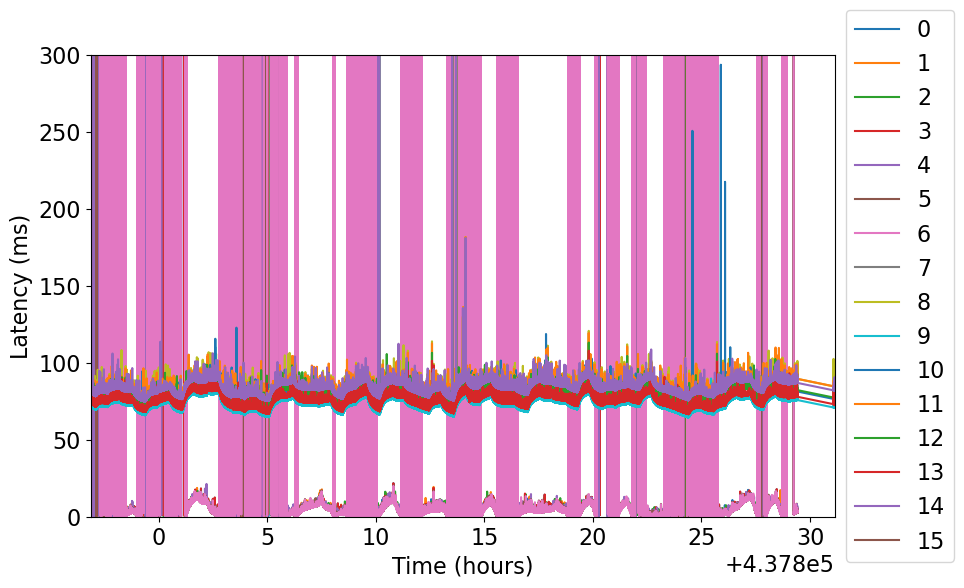

Node: vultrlondon (8) OWD


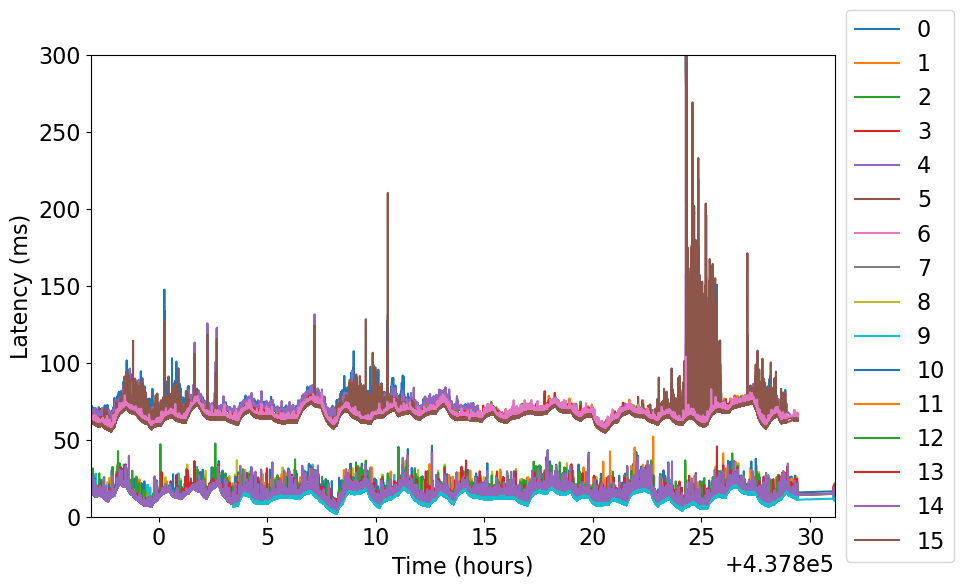

Node: vultrmadrid (9) OWD


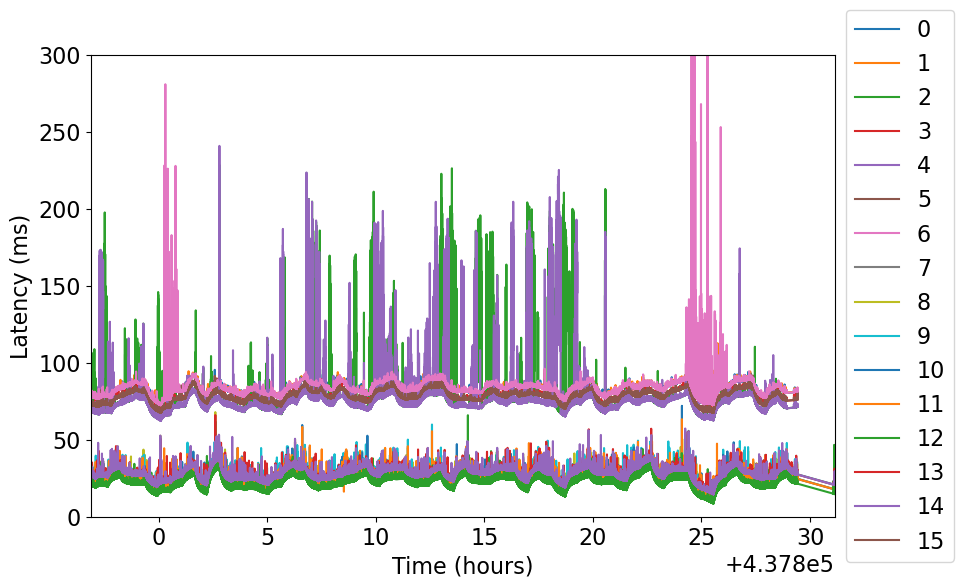

Node: vultrmelbourne (10) OWD


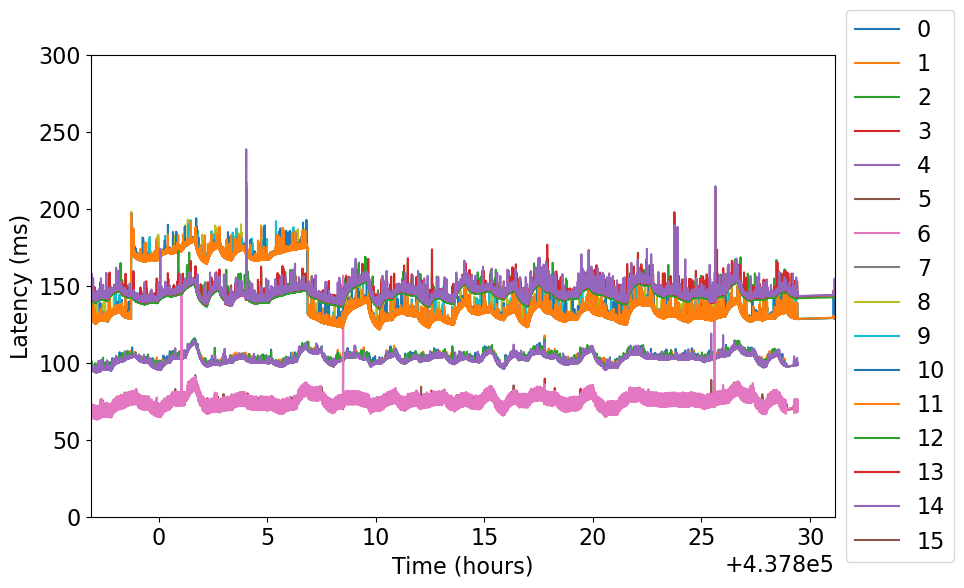

Node: vultrmexicocity (11) OWD


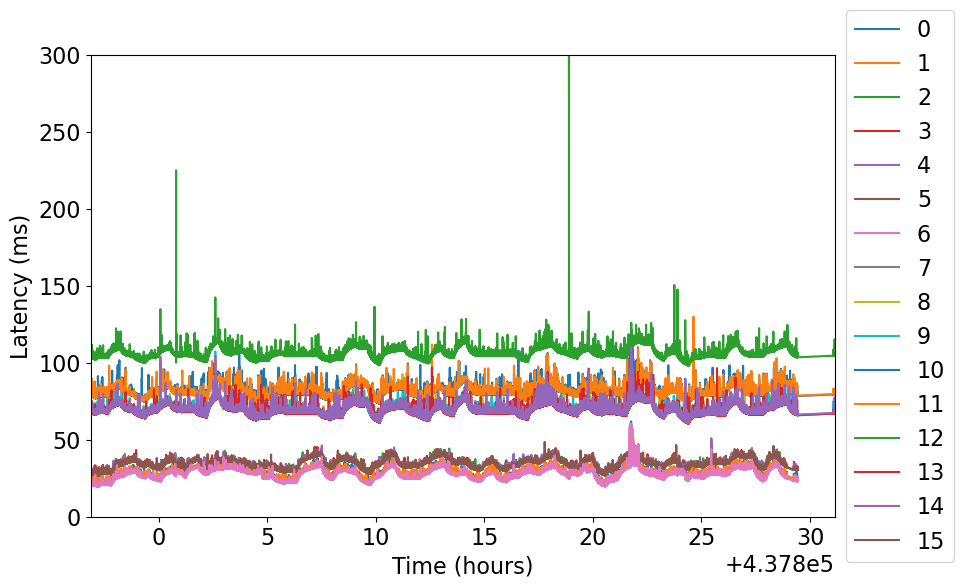

Node: vultrmiami (12) OWD


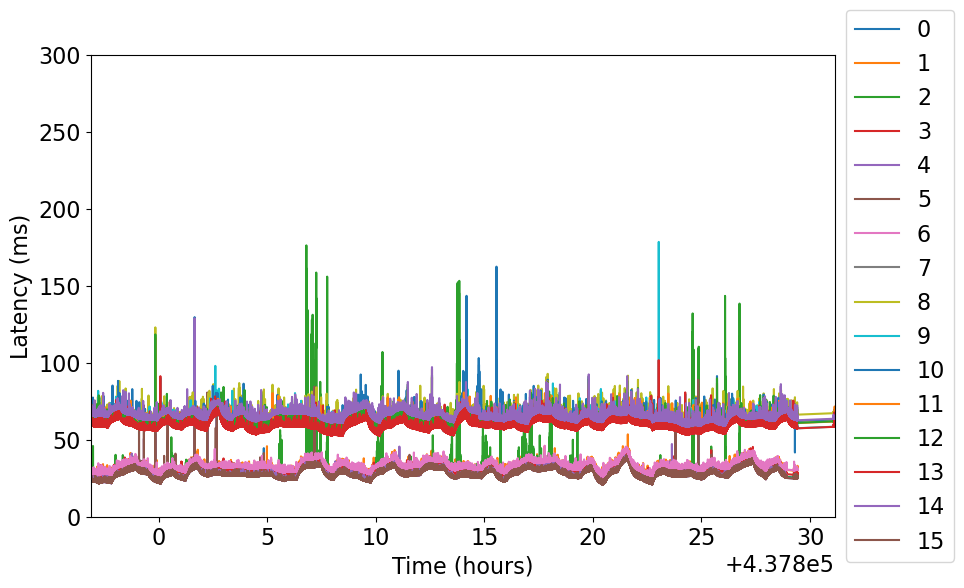

Node: vultrmumbai (13) OWD


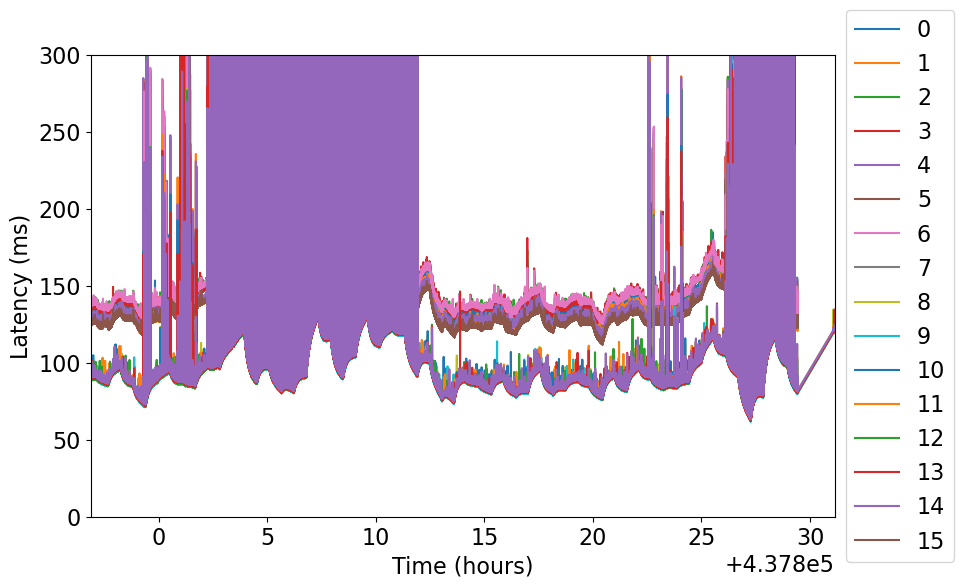

Node: vultrnj2 (14) OWD


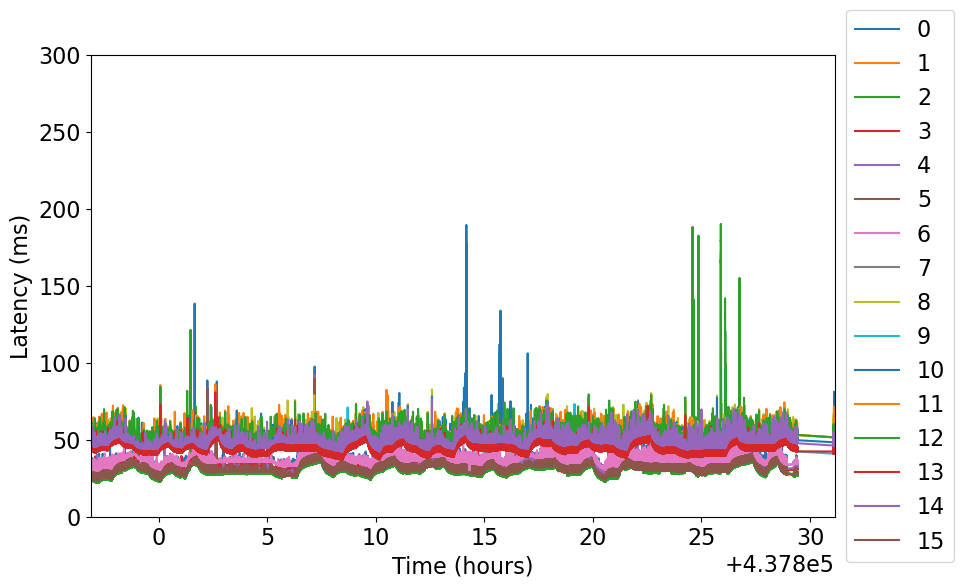

Node: vultrparis (15) OWD


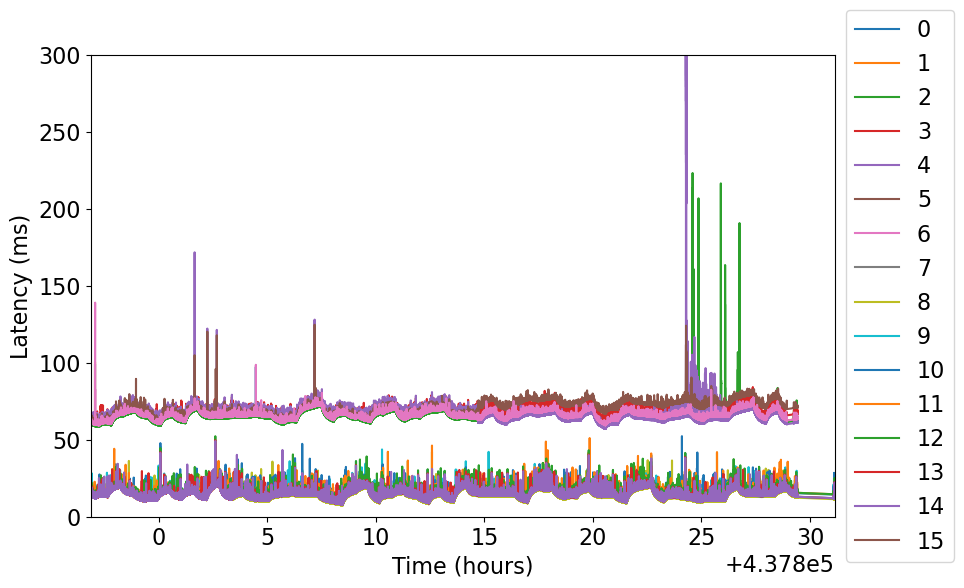

Node: vultrsaopaulo (16) OWD


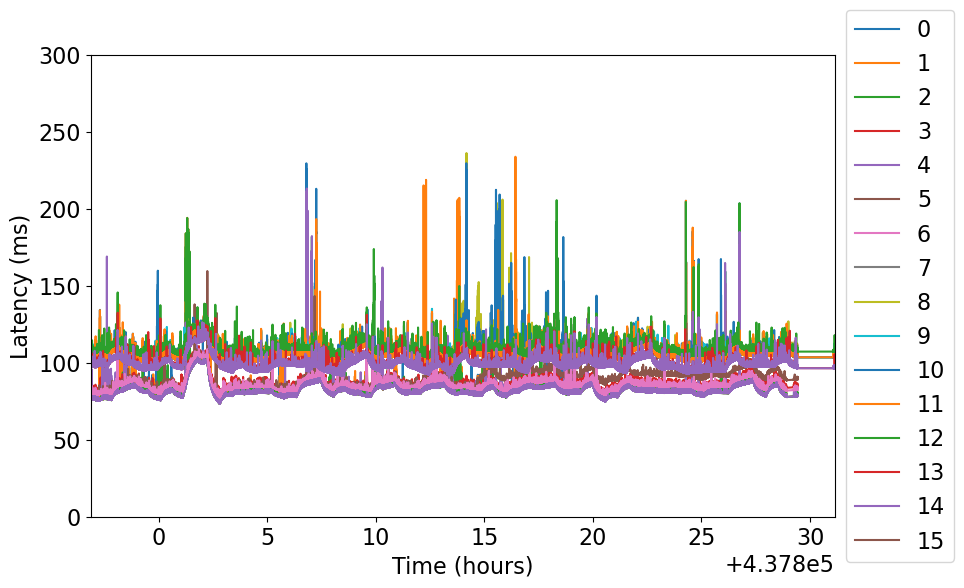

Node: vultrseattle (17) OWD


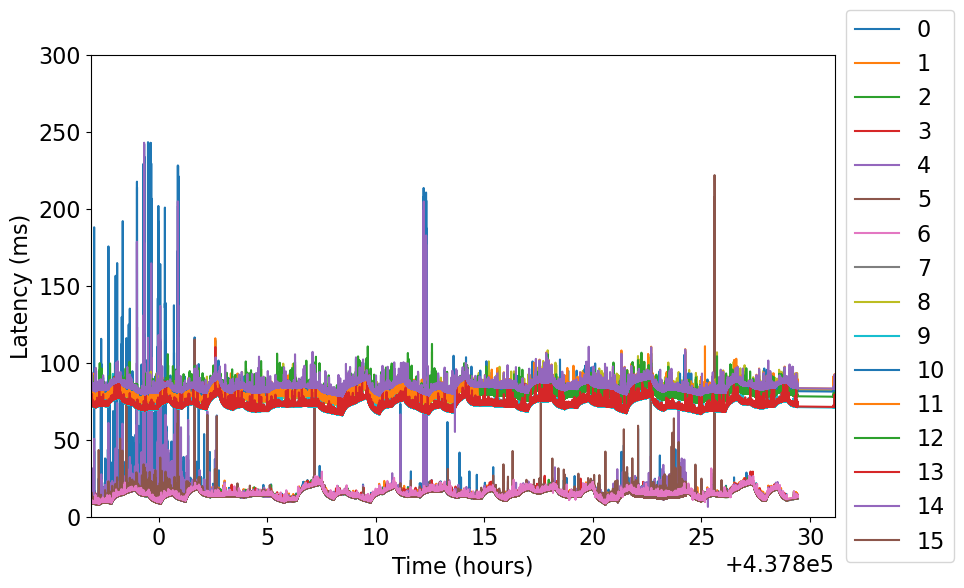

Node: vultrseoul (18) OWD


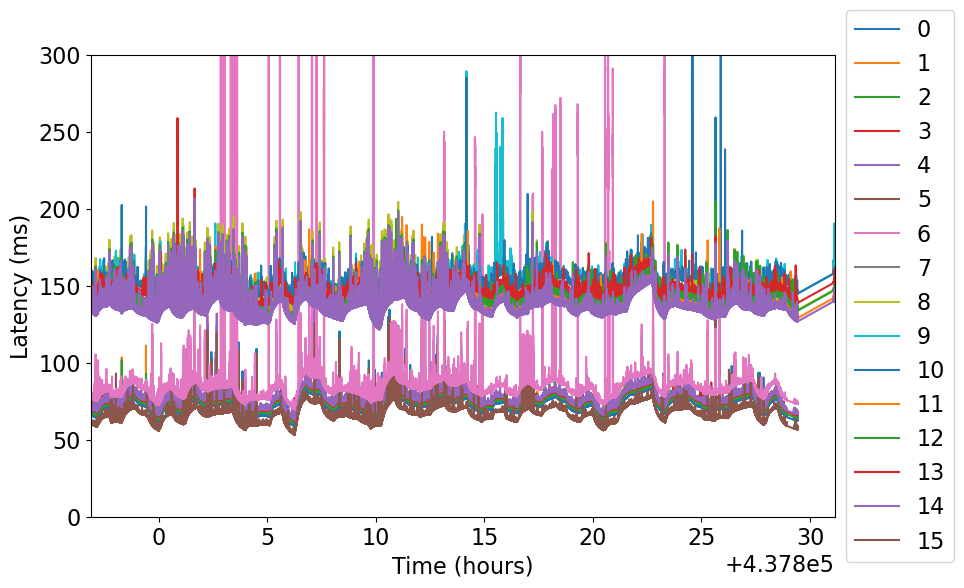

Node: vultrsiliconvalley (19) OWD


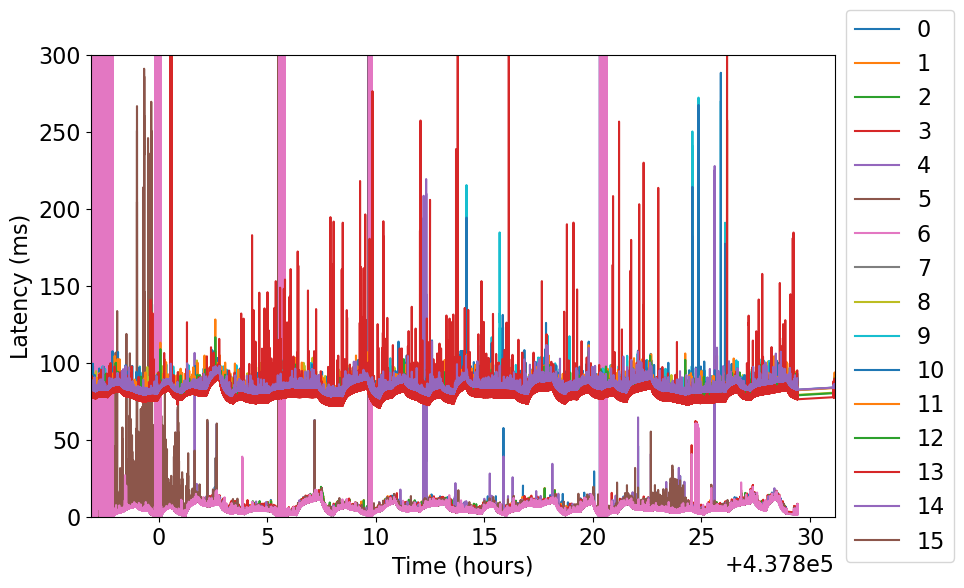

Node: vultrsingapore (20) OWD


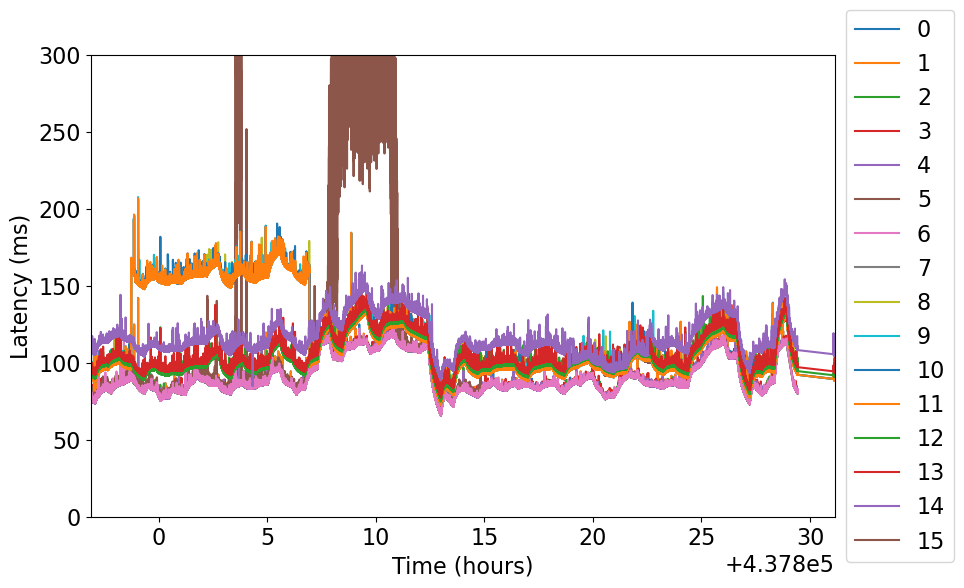

Node: vultrstockholm (21) OWD


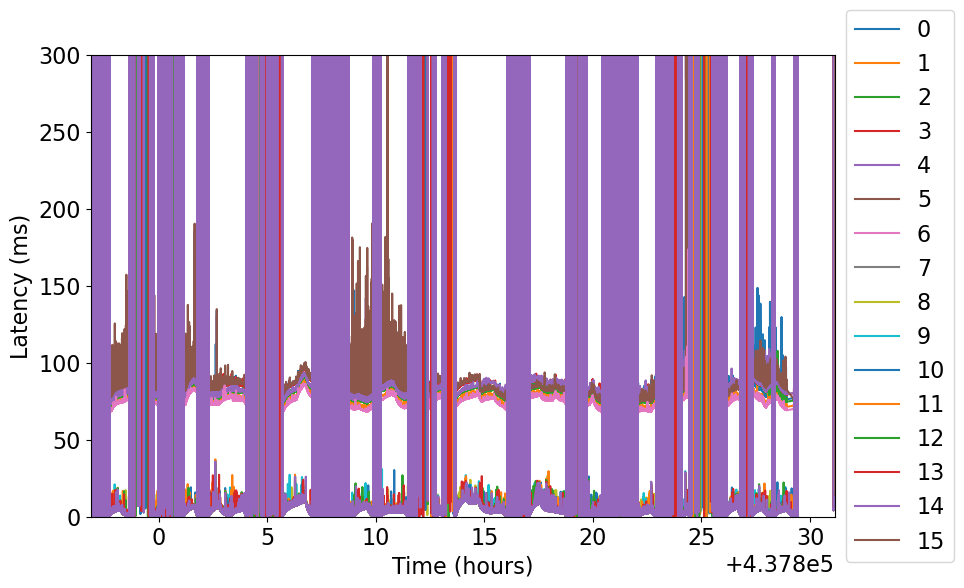

Node: vultrsydney (22) OWD


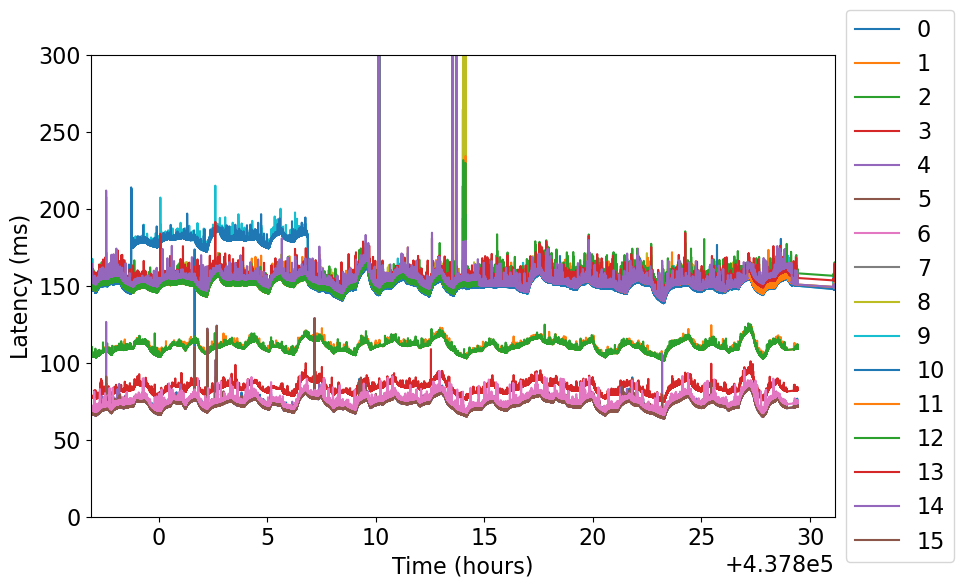

Node: vultrtokyo (23) OWD


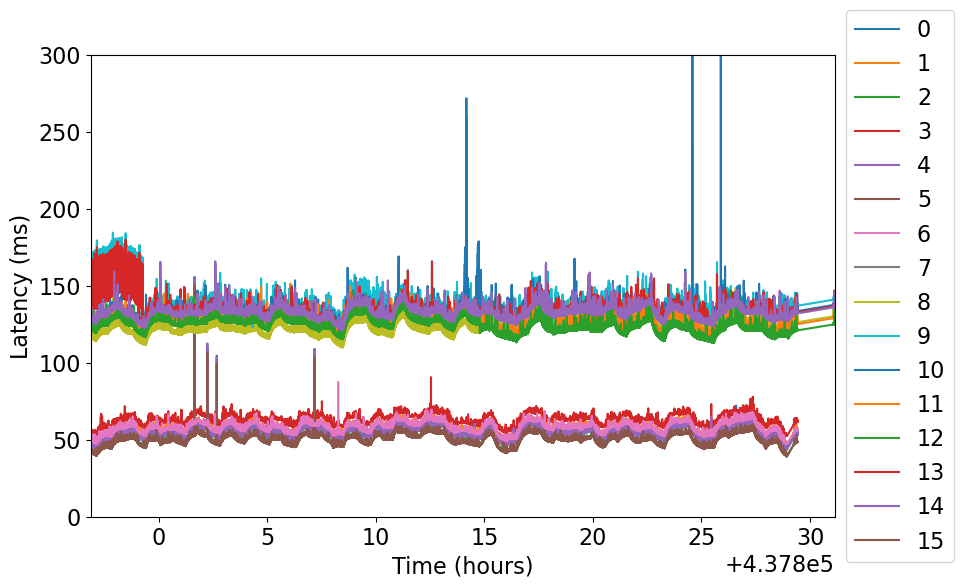

Node: vultrtoronto (24) OWD


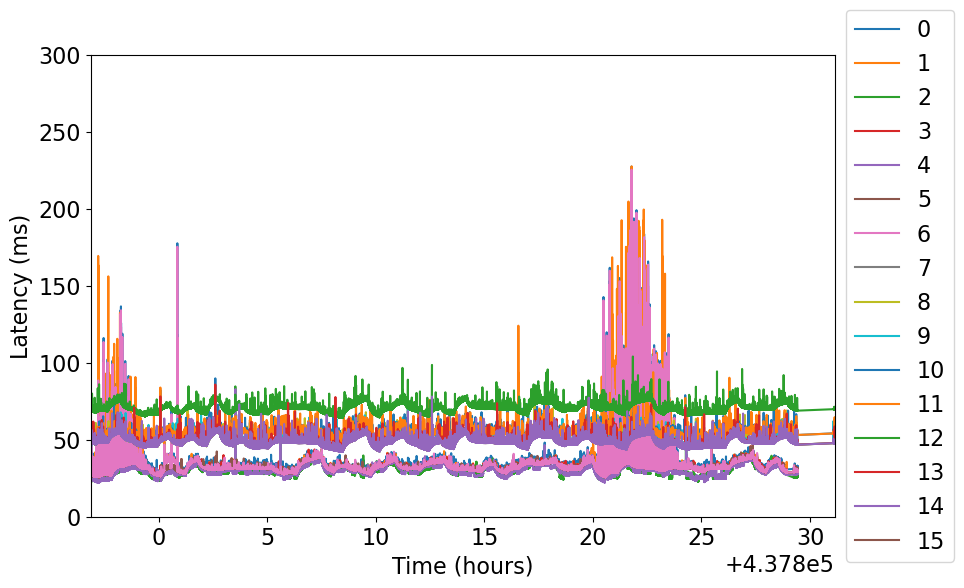

In [37]:
#for node in [nodeNamesToIDs["vultrsydney"]]:
for node in nodeIDsToNames:
    print(f"Node: {nodeIDsToNames[node]} ({node}) OWD")
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(12, 6))
    tstartGraph = tmin # 25, 30
    tendGraph = tmax
    #tstartGraph = 1 #10
    #tendGraph = 1.0002 #11
    #tstartGraph = 49
    #tendGraph = 51
    
    
    for prefix in owdPerSource[node]:
        #if not dst in ["GTT", "Telia"]:
        #    continue
        pointsInRange = owdPerSource[node][prefix][(owdPerSource[node][prefix]['time'] > tstartGraph) & (owdPerSource[node][prefix]['time'] < tendGraph)]
        ax.plot(pointsInRange['time'], pointsInRange['owd'], "-", label=prefix) # consider ".-" marker for dots on line
    
    #for dst in owpdatalabm:
    #    if not legendMapBM[dst] in ["GTT", "Telia"]:
    #        continue
    #    ax.plot(owpdatalabm[dst][0], owpdatalabm[dst][1], label=f"{legendMapBM[dst]} Bare Metal")
    
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    
    plt.xlim([tstartGraph, tendGraph])
    #plt.xlim([tmin, tmax])
    
    plt.ylim([0, 300])
    
    
    ax.set_ylabel('Latency (ms)')
    ax.set_xlabel('Time (hours)')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.title("Latency of different transit providers vultr LA to NJ across time")
    plt.show()
    
    #print(f"Node: {nodeIDsToNames[node]} Skipped Sequences")
    #
    #plt.rcParams.update({'font.size': 16})
    #fig, ax = plt.subplots(figsize=(12, 6))
    ##tstartGraph = tmin # 25, 30
    ##tendGraph = tmax
    #
    #
    #for prefix in owdPerSource[node]:
    #    #if not dst in ["GTT", "Telia"]:
    #    #    continue
    #    pointsInRange = owdPerSource[node][prefix][(owdPerSource[node][prefix]['time'] > tstartGraph) & (owdPerSource[node][prefix]['time'] < tendGraph)]
    #    ax.plot(pointsInRange['time'], pointsInRange['ss'], label=prefix)
    #
    ##for dst in owpdatalabm:
    ##    if not legendMapBM[dst] in ["GTT", "Telia"]:
    ##        continue
    ##    ax.plot(owpdatalabm[dst][0], owpdatalabm[dst][1], label=f"{legendMapBM[dst]} Bare Metal")
    #
    #
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #
    #
    #plt.xlim([tstartGraph, tendGraph])
    ##plt.xlim([tmin, tmax])
    #
    #plt.ylim([0, 10])
    #
    #
    #ax.set_ylabel('Dropped Packets')
    #ax.set_xlabel('Time (hours)')
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ##plt.title("Latency of different transit providers vultr LA to NJ across time")
    #plt.show()
    #

In [65]:
sectionCount = 5

sectionwiseMeanLA = {}
# Compute section count.
totalRecCount = 0
for dst in owdPerDestinationLA:
    totalRecCount += len(owdPerDestinationLA[dst])

sectionSize = totalRecCount // sectionCount + 1 # We don't want a single hanging section.
print(f"Section Size: {sectionSize}")
for dst in owdPerDestinationLA:
    sectionwiseMeanLA[dst] = owdPerDestinationLA[dst].groupby(owdPerDestinationLA[dst].index // sectionSize).agg(
        {'time': 'max', 'owd':'mean'})

In [66]:
sectionwiseMeanLA['NTT']

,time,owd
0,42.957065,37.880351
1,85.990838,37.828800
2,128.827399,37.134387
3,171.514113,35.540374
4,214.641910,35.602289


In [67]:
sectionwiseMeanLA['Cogent']

,time,owd
0,42.957065,36.497058
1,85.990838,36.435899
2,128.827399,36.205890
3,171.514110,36.276942
4,214.646646,36.197110


In [20]:
%matplotlib qt


ImportError: Failed to import any qt binding

In [14]:
owddfla.groupby(by='time').min().mean()

KeyboardInterrupt: 

In [11]:
l = [[1, 2, 3], [1, None, 4], [2, 1, 3], [1, 2, 2]]
df = pandas.DataFrame(l, columns=["a", "b", "c"])
df.groupby(by=["b"]).min().mean()

a    1.5
c    2.5
dtype: float64

In [204]:
averageNTTLatency = avg(owpdatala[transitToDst["NTT"]][1])
averageGTTLatency = avg(owpdatala[transitToDst["GTT"]][1])
averageCogentLatency = avg(owpdatala[transitToDst["Cogent"]][1])
optimalLatencyList = []
optimalLatencyCogentVsNTTList = []
for i in range(len(owpdatala[transitToDst["GTT"]][1])):
    indexMin = float("inf")
    for dst in owpdatala:
        if owpdatala[dst][1][i] < indexMin:
            indexMin = owpdatala[dst][1][i]
    optimalLatencyList.append(indexMin)
    optimalLatencyCogentVsNTTList.append(min(owpdatala[transitToDst["NTT"]][1][i], owpdatala[transitToDst["Cogent"]][1][i]))
averageOptimalLatency = avg(optimalLatencyList)
averageOptimalNTTVsCogentLatency = avg(optimalLatencyCogentVsNTTList)



In [205]:
averageNTTLatencynj = avg(owpdatanj[transitToDstNJ["NTT"]][1])
averageGTTLatencynj = avg(owpdatanj[transitToDstNJ["GTT"]][1])
optimalLatencyListnj = []
for i in range(len(owpdatanj[transitToDstNJ["GTT"]][1])):
    indexMin = float("inf")
    for dst in owpdatanj:
        if owpdatanj[dst][1][i] < indexMin:
            indexMin = owpdatanj[dst][1][i]
    optimalLatencyListnj.append(indexMin)
averageOptimalLatencynj = avg(optimalLatencyListnj)

In [19]:
owdPerDestinationNJ['NTT']['owd'].mean()

36.60957942537959

In [20]:
owdPerDestinationNJ['GTT']['owd'].mean()

28.844160932371942

In [21]:
owdPerDestinationLA['NTT']['owd'].mean()

36.79602097442305

In [22]:
owdPerDestinationLA['GTT']['owd'].mean()

28.458839951698415

In [9]:
tmax-tmin

214.64664875513978

In [10]:
tmaxnj- tminnj # 7 tenths of an ms imprevement on average by using dynamic algorithm.

206.56529638575182

In [23]:
gttTrace = owdPerDestinationNJ['GTT']
gttTrace[(gttTrace['time'] > 47.8) & (gttTrace['time'] < 48)]['owd'].min()




28.284897

In [1]:
owddfla

NameError: name 'owddfla' is not defined

In [191]:
averageNTTLatency

216329703.66666666

In [192]:
averageCogentLatency

217744361.6